<a href="https://colab.research.google.com/github/dinggga/super-broccoli/blob/main/220624hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **위성 이미지 분류**

In [1]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

import tensorflow_datasets as tfds

In [2]:
DATA_DIR = "dataset/"   

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                        shuffle_files=True, 
                                        as_supervised=True,
                                        with_info=True, # 메타 정보
                                        data_dir=DATA_DIR) # 파일 저장 위치 지정
print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to dataset/eurosat/rgb/2.0.0.incompleteLIROUY/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [3]:
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

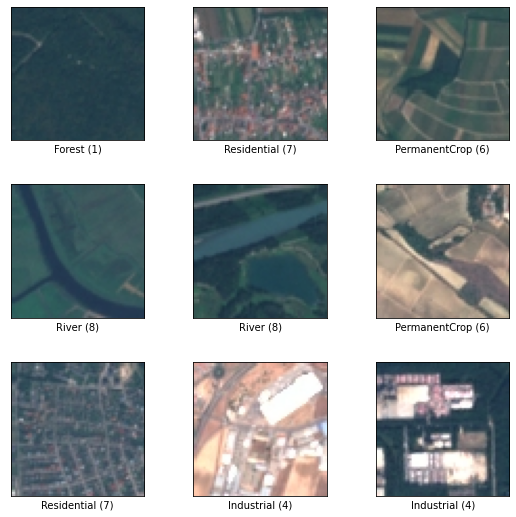

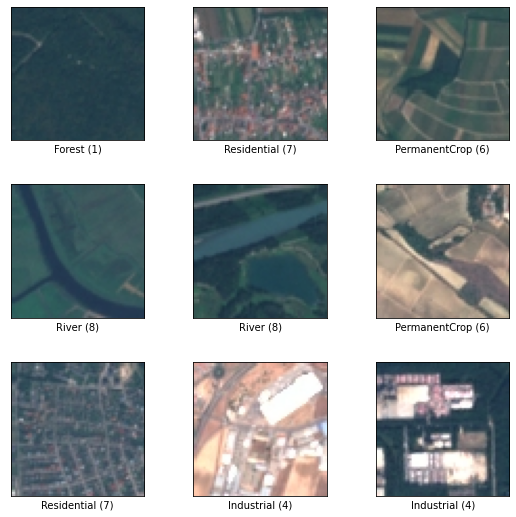

In [4]:
# 데이터 확인
tfds.show_examples(train_ds, info)

,image,label
0,,9 (SeaLake)
1,,8 (River)
2,,9 (SeaLake)
3,,9 (SeaLake)
4,,9 (SeaLake)
5,,0 (AnnualCrop)
6,,2 (HerbaceousVegetation)
7,,0 (AnnualCrop)
8,,0 (AnnualCrop)
9,,2 (HerbaceousVegetation)

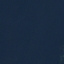
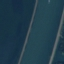
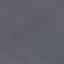
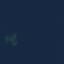
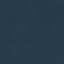
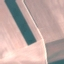
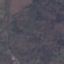
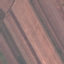
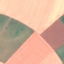
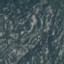

In [5]:
# as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

In [6]:
# 목표 클래스의 개수
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


In [7]:
# 숫자 레이블을 활용해 문자열 메타 데이터로 변환
print(info.features["label"].int2str(6))

PermanentCrop


In [8]:
# 데이터 전처리 파이프라인 
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화, float32 변환
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [9]:
# 모델 훈련 및 검증

# Sequential API를 사용하여 샘플 모델 생성
def build_model():
  model = tf.keras.Sequential([
                               #Convolution층
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
                               tf.keras.layers.MaxPooling2D((2,2)),

                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
                               tf.keras.layers.MaxPooling2D((2,2)),
                               #Classifier 출력층
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(128, activation='relu'), 
                              tf.keras.layers.Dropout(0.3),  
                              tf.keras.layers.Dense(64, activation='relu'), 
                              tf.keras.layers.Dropout(0.3),              
                              tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
  ])

  return model

model = build_model()

In [10]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data, 
                    validation_data=valid_data, 
                    epochs=50)

Epoch 1/50
338/338 [==============================] - 176s 518ms/step - loss: 1.6932 - accuracy: 0.4113 - val_loss: 1.7471 - val_accuracy: 0.3922
Epoch 2/50
338/338 [==============================] - 172s 509ms/step - loss: 1.2689 - accuracy: 0.5476 - val_loss: 0.9588 - val_accuracy: 0.6674
Epoch 3/50
338/338 [==============================] - 170s 502ms/step - loss: 1.0909 - accuracy: 0.6086 - val_loss: 0.8510 - val_accuracy: 0.6672
Epoch 4/50
338/338 [==============================] - 169s 501ms/step - loss: 0.9393 - accuracy: 0.6695 - val_loss: 0.7127 - val_accuracy: 0.7728
Epoch 5/50
338/338 [==============================] - 170s 502ms/step - loss: 0.8565 - accuracy: 0.7030 - val_loss: 0.7088 - val_accuracy: 0.7559
Epoch 6/50
338/338 [==============================] - ETA: 0s - loss: 0.7929 - accuracy: 0.7229

KeyboardInterrupt: ignored

계속해서 실행해도 런타임 오류가 나서 아래는 코드만 제출합니다ㅠㅠ

In [ ]:
# 손실함수, 정확도 그래프 그리기
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 50)

In [ ]:
# 데이터 증강
# 샘플 이미지
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label));

In [ ]:
# 데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].imshow(original)
    axes[0].set_title('Original')

    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')

    plt.show()

In [ ]:
# 좌우 뒤집기 
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

In [ ]:
# 상하 뒤집기 
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

In [ ]:
# 회전 
rotate90 = tf.image.rot90(image) # 이미지를 반시계 방향으로 90도 회전
plot_augmentation(image, rotate90)

In [ ]:
# transpose 
transpose = tf.image.transpose(image) # 이미지 텐서 행렬의 행과 열 위치 바꿔줌
plot_augmentation(image, transpose)

In [ ]:
# 이미지 자르기 1
crop1 = tf.image.central_crop(image, central_fraction=0.6) # 이미지의 중심에서 일정 부분을 잘라냄
plot_augmentation(image, crop1)

In [ ]:
# 이미지 자르기 2 
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20) # 사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64, 64, 3]) # 이미지를 원본 크기와 같게 자름
plot_augmentation(image, crop2)

In [ ]:
# 이미지 밝기 
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

In [ ]:
# 이미지 채도 
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

In [ ]:
# 이미지 대비  
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

In [ ]:
# 이미지 증강 전처리
def data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image) # 상하 반전    
    image = tf.image.random_brightness(image, max_delta=0.3) # 밝기 변화 
    image = tf.image.random_crop(image, size=[64, 64, 3])

    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화

    return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

print(train_aug)
print(valid_aug)

In [ ]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug, 
                            validation_data=valid_aug, 
                            epochs=50)

In [ ]:
# 손실함수, 정확도 그래프 그리기 
plot_loss_acc(aug_history, 50)

In [ ]:
# ResNet 사전 학습 모델

# Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False, # 기존 ResNet 모델의 Top 층을 제거 -> 최종 분류기를 대체하여 추가
                              weights='imagenet',
                              input_shape=[64, 64, 3]) # 위성 이미지의 크기 지정 -> 케라스에서 이미지 크기를 지정한 크기로 맞춰서 줄여줌

# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
from keras.utils.vis_utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='/content/resnet50.png')

In [ ]:
# Top 층에 Classifier 추가

def build_trainsfer_classifier():

    model = tf.keras.Sequential([

        # Pre-trained Base 
        pre_trained_base,
        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dropout(0.3),  
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.3),     
        # 10개 클래스에 대한 다중 분류 -> Dense 레이어의 노드 개수 NUM_CLASSES와 softmax 활성화 함수 지정         
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'), # NUM_CLASSES : 위성 이미지의 클래스 레이블 개수(10)
    ])

    return model

# 모델 구조
tc_model = build_trainsfer_classifier()    
tc_model.summary()

In [ ]:
# 모델 컴파일
tc_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# 모델 훈련
tc_history = tc_model.fit(train_aug, 
                          validation_data=valid_aug, 
                          epochs=50)

In [ ]:
# 손실함수, 정확도 그래프 그리기 
plot_loss_acc(tc_history, 50)